In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt


In [7]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from keras.utils.np_utils import to_categorical
K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)


In [3]:
inputDim= 10

In [4]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]


In [5]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)


# Generator


In [6]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=inputDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.add(Flatten())
generator.compile(loss='mse', optimizer=adam)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 28, 28)        0         
__________

In [8]:

gLosses = []


In [9]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images_vae/vae_loss_epoch_%d.png' % epoch)


# Create a wall of generated MNIST images


In [10]:
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):

    
    pickup_batch = np.random.randint(0, X_test.shape[0], size=examples)

    our_input = to_categorical(y_test[pickup_batch],inputDim)
    
    generatedImages = generator.predict(our_input).reshape(examples,1,28,28)
#     print(generatedImages)
    
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images_vae/vae_generated_image_epoch_%d.png' % epoch)


# Save the generator network (and weights) for later use


In [11]:
def saveModels(epoch):
    generator.save('models/vae_epoch_%d.h5' % epoch)


In [13]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] // batchSize
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)

        for _ in range(batchCount):
                        
            pickup_batch = np.random.randint(0, X_train.shape[0], size=batchSize)

            our_input = to_categorical(y_train[pickup_batch],inputDim)
            
            
            imageBatch_target = X_train[pickup_batch].reshape(batchSize,-1)

            gloss = generator.train_on_batch(our_input,imageBatch_target)

        # Store loss of most recent batch from this epoch

        gLosses.append(gloss)
        print(gloss)
        if e == 1 or e % 2 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)



## Training

In [14]:
train(10, 128)

Epochs: 10
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
0.22118886
--------------- Epoch 2 ---------------
0.21757375
--------------- Epoch 3 ---------------
0.20744973
--------------- Epoch 4 ---------------
0.21792457
--------------- Epoch 5 ---------------
0.2156351
--------------- Epoch 6 ---------------
0.20588174
--------------- Epoch 7 ---------------
0.21714678
--------------- Epoch 8 ---------------
0.2063472
--------------- Epoch 9 ---------------
0.2218733
--------------- Epoch 10 ---------------
0.21469784


## Testing


In [4]:
%matplotlib inline


In [5]:
from keras.models import load_model
generator=load_model('models/vae_epoch_10.h5')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


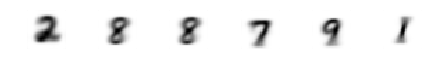

In [11]:
generatedImages = generator.predict(to_categorical(np.array([2,8,8,7,9,1]),inputDim))

generatedImages = generatedImages.reshape(generatedImages.shape[0],1,28,28)

## To plot ###
dim=(10, 10)
figsize=(10, 10)

plt.figure(figsize=figsize)
for i in range(generatedImages.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
    
plt.tight_layout()
plt.show()



In [ ]:
# generatedImages.shape